In [35]:
%load_ext autoreload 
#hopefully this will reload the modules when they are changed specifically when i change the plotting modules
%autoreload 2

In [36]:
import iapi_TNG as iapi
#this package contains useful functions for downloading the neccessary data
#make sure you have edited iapi_TNG.py to include your personal API key
import numpy as np
import h5py #most TNG data is downloaded as hdf5 files
import matplotlib.pyplot as plt
import matplotlib.markers as mkr
import os.path
from os import path
import scipy.stats as st
from utilities.draw_contour import conplot
from utilities.plot_gen import plot_gen, plot_wcontour
from utilities.bin_data import bin_data, avg, sort_mass
#from scipy.stats import binned_statistic
 
baseUrl = 'http://www.tng-project.org/api/'

## Initialization

In [2]:
####EDIT THIS FOR YOUR MACHINE#####
#get current director
'!pwd'
#get current directory
currentdirc=!pwd
print(currentdirc)
dirc= ' '.join(currentdirc) + '/TNG_workshop_data/'
print(f"current dirc {dirc}")

['/Users/alexpoulin/Downloads/git/TNG/TNG_workshop']
current dirc /Users/alexpoulin/Downloads/git/TNG/TNG_workshop/TNG_workshop_data/


In [3]:
###specify which simulation you want to explore###
sim='TNG100-1'

In [4]:
r=iapi.get(baseUrl)
print(r)
#check the properties of the simulation you have selected
simUrl = baseUrl+sim
print(simUrl) 
simdata = iapi.get(simUrl)
print(simdata['description'])

{'simulations': [{'name': 'Illustris-1', 'num_snapshots': 134, 'url': 'http://www.tng-project.org/api/Illustris-1/'}, {'name': 'Illustris-1-Dark', 'num_snapshots': 136, 'url': 'http://www.tng-project.org/api/Illustris-1-Dark/'}, {'name': 'Illustris-2', 'num_snapshots': 136, 'url': 'http://www.tng-project.org/api/Illustris-2/'}, {'name': 'Illustris-2-Dark', 'num_snapshots': 136, 'url': 'http://www.tng-project.org/api/Illustris-2-Dark/'}, {'name': 'Illustris-3', 'num_snapshots': 136, 'url': 'http://www.tng-project.org/api/Illustris-3/'}, {'name': 'Illustris-3-Dark', 'num_snapshots': 136, 'url': 'http://www.tng-project.org/api/Illustris-3-Dark/'}, {'name': 'TNG100-1', 'num_snapshots': 100, 'url': 'http://www.tng-project.org/api/TNG100-1/'}, {'name': 'TNG100-1-Dark', 'num_snapshots': 100, 'url': 'http://www.tng-project.org/api/TNG100-1-Dark/'}, {'name': 'TNG100-2', 'num_snapshots': 100, 'url': 'http://www.tng-project.org/api/TNG100-2/'}, {'name': 'TNG100-2-Dark', 'num_snapshots': 100, 'url

In [5]:
simdata.keys()

dict_keys(['name', 'description', 'name_alt', 'boxsize', 'z_start', 'z_final', 'cosmology', 'omega_0', 'omega_L', 'omega_B', 'hubble', 'physics_model', 'has_cooling', 'has_starformation', 'has_winds', 'has_blackholes', 'mass_gas', 'mass_dm', 'softening_dm_comoving', 'softening_stars_comoving', 'softening_blackholes_comoving', 'softening_gas_comoving', 'softening_dm_max_phys', 'softening_stars_max_phys', 'softening_blackholes_max_phys', 'softening_gas_max_phys', 'softening_gas_factor', 'softening_gas_comoving_min', 'num_dm', 'num_tr_mc', 'num_tr_vel', 'longids', 'is_uniform', 'is_zoom', 'is_subbox', 'num_files_snapshot', 'num_files_groupcat', 'num_files_rockstar', 'num_files_lhalotree', 'num_files_sublink', 'num_files_ctrees', 'filesize_lhalotree', 'filesize_sublink', 'filesize_ctrees', 'filesize_ics', 'filesize_simulation', 'has_fof', 'has_subfind', 'has_rockstar', 'has_lhalotree', 'has_sublink', 'has_ctrees', 'permission_required', 'num_snapshots', 'url', 'parent_simulation', 'child_s

## Get Data

In [6]:
if not os.path.exists(dirc + 'catalogs'):
    os.makedirs(dirc + 'catalogs')
    print(f'created directory: {dirc} "catalogs"')
if not os.path.exists(dirc + 'catalogs/SubhaloFlag'):
    os.makedirs(dirc + 'catalogs/SubhaloFlag')
    print(f'created directory: {dirc} "/catalogs/SubhaloFlag"')
flag=iapi.getSubhaloField('SubhaloFlag',simulation=sim,fileName=dirc+'catalogs/SubhaloFlag',rewriteFile=0)

In [7]:
#let's fetch a field that will tell us about the mass of the galaxy
#SubhaloMassType gives the total mass of all bound particles, separated by particle type
mass=iapi.getSubhaloField('SubhaloMassType',simulation=sim,fileName=dirc+'catalogs/MassType',rewriteFile=0)
print(mass.shape)

(4371211, 6)


In [8]:
#Pull the stellar mass: 
print(mass[:,3])
stellar_mass=mass[:,4]
print(stellar_mass)

[0. 0. 0. ... 0. 0. 0.]
[251.01631   37.85255   42.482437 ...   0.         0.         0.      ]


Mass units in: 10^10 𝑀⊙/ℎ

In [9]:
h = simdata.get('hubble')
print(h)
stellar_mass=stellar_mass*10**10/h #convert to one solar masses

0.6774


Save SFR

In [10]:
if not os.path.exists(dirc + 'catalogs/SubhaloSFR'):
    os.makedirs(dirc + 'catalogs/SubhaloSFR')
    print(f'created directory: {dirc} "catalogs/SubhaloSFR"')
sfr_inst = iapi.getSubhaloField('SubhaloSFR',simulation = sim,fileName=dirc+'catalogs/SubhaloSFR',rewriteFile=0)

Get group number

In [11]:
if not os.path.exists(dirc + 'catalogs/SubhaloGrNr'):
    os.makedirs(dirc + 'catalogs/SubhaloGrNr')
    print(f'created directory: {dirc} "catalogs/SubhaloGrNr"')
groupNum = iapi.getSubhaloField('SubhaloGrNr',simulation = sim,fileName=dirc+'catalogs/SubhaloGrNr',rewriteFile=0)

Get magnetic field

In [12]:
if not os.path.exists(dirc + 'catalogs/SubhaloBfldHalo'):
    os.makedirs(dirc + 'catalogs/SubhaloBfldHalo')
    print(f'created directory: {dirc} "catalogs/SubhaloBfldHalo"')
Bfld = iapi.getSubhaloField('SubhaloBfldHalo',simulation = sim,fileName=dirc+'catalogs/SubhaloBfldHalo',rewriteFile=0)
#Multiply B field by h*2.6*10^-6 to get Gauss
Bfld = Bfld*h*2.6*10**-6

In [13]:
print(Bfld)
#check how many nans
print(np.sum(np.isnan(Bfld)))
#check how many non nans
print(np.sum(~np.isnan(Bfld)))

[3.6186711e-07 2.6890854e-07 3.1266095e-06 ...           nan           nan
           nan]
4003872
367339


In [14]:
print(stellar_mass)

[3.7055847e+12 5.5879172e+11 6.2713961e+11 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00]


Restrict to 10^9 solar masses

In [15]:
subID=np.arange(0,len(stellar_mass))

mask = (flag==1) & (stellar_mass>10**9)

print("Before trimming, there are ", len(stellar_mass), ' subhalos in our catalog')

IDs_m=subID[mask]
s_mass=stellar_mass[mask]
sfr_i = sfr_inst[mask]
groupNum_m = groupNum[mask]
Bfld_m = Bfld[mask]


print("After trimming, there are ", len(s_mass), ' subhalos in our catalog')

Before trimming, there are  4371211  subhalos in our catalog
After trimming, there are  21052  subhalos in our catalog


## test subhalo id

In [16]:
print(f"ID: {IDs_m[0]}, mass: {s_mass[0]}, group number: {groupNum_m[0]}, Bfld: {Bfld_m[0]}")

ID: 0, mass: 3705584746496.0, group number: 0, Bfld: 3.6186710872243566e-07


## Seperate satellites from centrals

In [17]:
print(s_mass.shape)
print(sfr_i.shape)
print(groupNum_m.shape)
print(Bfld_m.shape)
print(IDs_m.shape)
#should be same indexing for all three

(21052,)
(21052,)
(21052,)
(21052,)
(21052,)


In [18]:
# Unique group identifiers
print(all(groupNum_m[i] <= groupNum_m[i + 1] for i in range(len(groupNum_m) - 1)))
##prints true if already sorted
groups = sorted(set(groupNum_m))  # Ensure unique and ordered group identifiers
#groups = groupNum_m

# Initialize separate resulting arrays for a, b, and group c
grouped_s_mass = [[] for _ in groups]  # Each sub-list will store values ofmass
grouped_sfr_i = [[] for _ in groups]  # Each sub-list will store values of sfr
grouped_groupNum_i = [[] for _ in groups]  # Each sub-list will store corresponding group identifiers
grouped_bfld = [[] for _ in groups]  # Each sub-list will store values of Bfld
grouped_ids = [[] for _ in groups]  # Each sub-list will store values of ids

# Group values into separate lists
for i in range(len(groupNum_m)):
    group_index = groups.index(groupNum_m[i])  # Determine the index for each group
    #group_index = np.where(groups == groupNum_m[i])[0]
    grouped_s_mass[group_index].append(s_mass[i])
    grouped_sfr_i[group_index].append(sfr_i[i])
    grouped_bfld[group_index].append(Bfld_m[i])
    grouped_groupNum_i[group_index].append(groupNum_m[i])
    grouped_ids[group_index].append(IDs_m[i])

# Display the results
for i, group in enumerate(groups):
    print(f"Group {group}:")
    print(f"  s_mass: {grouped_s_mass[i]}")
    print(f"  sfr_i: {grouped_sfr_i[i]}")
    print(f"  Bfld: {grouped_bfld[i]}")
    print(f"  groupNum_i: {grouped_groupNum_i[i]}")
    print(f"  IDs: {grouped_ids[i]}")

True
Group 0:
  s_mass: [np.float32(3705584700000.0), np.float32(558791700000.0), np.float32(627139600000.0), np.float32(171551460000.0), np.float32(133340406000.0), np.float32(192150200000.0), np.float32(289372440000.0), np.float32(192698550000.0), np.float32(223140360000.0), np.float32(201115710000.0), np.float32(236774640000.0), np.float32(260189700000.0), np.float32(83734815000.0), np.float32(97074135000.0), np.float32(168427320000.0), np.float32(71538480000.0), np.float32(100577210000.0), np.float32(78666190000.0), np.float32(86144800000.0), np.float32(132973175000.0), np.float32(42819490000.0), np.float32(109763940000.0), np.float32(48091492000.0), np.float32(107320250000.0), np.float32(29036093000.0), np.float32(67762176000.0), np.float32(49894117000.0), np.float32(44136755000.0), np.float32(37582803000.0), np.float32(29564340000.0), np.float32(51341160000.0), np.float32(77012390000.0), np.float32(44120072000.0), np.float32(39299270000.0), np.float32(51320033000.0), np.float32(4

In [19]:
#most massive of group
centrals_mass = []
satellites_mass = []
centrals_bfld = []
satellites_bfld = []
centrals_ids = []
satellites_ids = []


# Find largest/central galaxy in each group
for i, group in enumerate(groups):
    max_s_mass = max(grouped_s_mass[i])  # Find the maximum value in the mass for this group
    #print(f"Group {group}:")
    #print(f"  Largest a: {max_s_mass}")
    centrals_mass.append(max_s_mass) 
    centrals_bfld.append(grouped_bfld[i][grouped_s_mass[i].index(max_s_mass)])  # Find the Bfld value for the central galaxy
    centrals_ids.append(grouped_ids[i][grouped_s_mass[i].index(max_s_mass)])  # Find the ID for the central galaxy
    satellites_mass.append(grouped_s_mass[i])
    satellites_bfld.append(grouped_bfld[i])
    satellites_mass[i].remove(max_s_mass)  # Remove the central galaxy from the list of satellites
    satellites_bfld[i].remove(centrals_bfld[i])  # Remove the central galaxy from the list of satellites
    satellites_ids.append(grouped_ids[i])
    satellites_ids[i].remove(centrals_ids[i])  # Remove the central galaxy from the list of satellites
    
print(centrals_mass)
print(satellites_mass)
print(centrals_bfld)
print(satellites_bfld)

print(centrals_ids)
print(satellites_ids)

print(len(centrals_mass))
print(len(satellites_mass))

#satellites_mass_fl = np.concatenate(satellites_mass).flatten()
#satellites_bfld_fl = np.concatenate(satellites_bfld).flatten()
#satellites_ids_fl = np.concatenate(satellites_ids).flatten()
    
#print(len(satellites_mass_fl))

[np.float32(3705584700000.0), np.float32(2285440000000.0), np.float32(2833792600000.0), np.float32(1424632000000.0), np.float32(1202325400000.0), np.float32(1340881100000.0), np.float32(2225182000000.0), np.float32(952085840000.0), np.float32(2094143800000.0), np.float32(2066222500000.0), np.float32(1750284400000.0), np.float32(1596471900000.0), np.float32(594922600000.0), np.float32(973366030000.0), np.float32(1184906600000.0), np.float32(957710300000.0), np.float32(935517200000.0), np.float32(1317181800000.0), np.float32(805841700000.0), np.float32(803658140000.0), np.float32(848021000000.0), np.float32(752950800000.0), np.float32(1546026200000.0), np.float32(744572300000.0), np.float32(759625900000.0), np.float32(776391700000.0), np.float32(869427840000.0), np.float32(907390940000.0), np.float32(583304800000.0), np.float32(765191060000.0), np.float32(811644700000.0), np.float32(675072800000.0), np.float32(981016050000.0), np.float32(767100900000.0), np.float32(409634440000.0), np.fl

In [20]:
print(centrals_mass)

print(satellites_mass[0])
print(centrals_mass[0])
print(centrals_bfld[0])
print(centrals_ids[0])
print(f"ID: {IDs_m[0]}, mass: {s_mass[0]}, group number: {groupNum_m[0]}, Bfld: {Bfld_m[0]}")


print(satellites_mass)
print(len(satellites_mass))

def flatten(xss):
    flat_list = []
    for xs in xss:
        #if len(xs) == 0:
        #    flat_list.append(np.nan)
        for x in xs:
            flat_list.append(x)
    return flat_list
    #return [x for xs in xss for x in xs]

satellites_mass_fl = flatten(satellites_mass)
satellites_bfld_fl = flatten(satellites_bfld)
satellites_ids_fl = flatten(satellites_ids)

print(len(satellites_mass_fl))


[np.float32(3705584700000.0), np.float32(2285440000000.0), np.float32(2833792600000.0), np.float32(1424632000000.0), np.float32(1202325400000.0), np.float32(1340881100000.0), np.float32(2225182000000.0), np.float32(952085840000.0), np.float32(2094143800000.0), np.float32(2066222500000.0), np.float32(1750284400000.0), np.float32(1596471900000.0), np.float32(594922600000.0), np.float32(973366030000.0), np.float32(1184906600000.0), np.float32(957710300000.0), np.float32(935517200000.0), np.float32(1317181800000.0), np.float32(805841700000.0), np.float32(803658140000.0), np.float32(848021000000.0), np.float32(752950800000.0), np.float32(1546026200000.0), np.float32(744572300000.0), np.float32(759625900000.0), np.float32(776391700000.0), np.float32(869427840000.0), np.float32(907390940000.0), np.float32(583304800000.0), np.float32(765191060000.0), np.float32(811644700000.0), np.float32(675072800000.0), np.float32(981016050000.0), np.float32(767100900000.0), np.float32(409634440000.0), np.fl

In [21]:
print(centrals_bfld)
print(satellites_bfld)
#check how many satellites_bfld are nan
print(sum(np.isnan(satellites_bfld_fl)))
#check how many or not nan
print(len(satellites_bfld_fl)-sum(np.isnan(satellites_bfld_fl)))


[np.float32(3.618671e-07), np.float32(4.31471e-07), np.float32(3.9145732e-07), np.float32(2.958836e-07), np.float32(3.9897145e-07), np.float32(2.9673654e-07), np.float32(3.1055524e-07), np.float32(2.1713574e-07), np.float32(3.2544168e-07), np.float32(3.4086793e-07), np.float32(2.9842604e-07), np.float32(2.7373292e-07), np.float32(2.557057e-07), np.float32(2.8566149e-07), np.float32(2.6046118e-07), np.float32(2.6976306e-07), np.float32(2.0394225e-07), np.float32(2.9001245e-07), np.float32(2.4000903e-07), np.float32(2.6617047e-07), np.float32(2.9015132e-07), np.float32(2.0617352e-07), np.float32(2.4779916e-07), np.float32(1.8149493e-07), np.float32(2.0650216e-07), np.float32(2.2713199e-07), np.float32(2.4888027e-07), np.float32(2.5012167e-07), np.float32(2.0964382e-07), np.float32(2.0949078e-07), np.float32(2.3063592e-07), np.float32(1.957686e-07), np.float32(2.317107e-07), np.float32(2.6239658e-07), np.float32(1.710722e-07), np.float32(2.3082198e-07), np.float32(2.0889779e-07), np.float

In [22]:
#Define isolated centrals as those with no star-forming satellites 
# (all other subhalos with the same SubhaloGrNr have SubhaloSFR=0)
#define non-isolated centrals as those with star-forming satellites:
# (at least one other subhalo with the same SubhaloGrNr has SubhaloSFR>0)
isolated_centrals_mass = []
isolated_centrals_bfld = []
non_isolated_centrals_mass = []
non_isolated_centrals_bfld = []

#for each group, check if there are any star-forming satellites
# if there are, the central is non-isolated so find the central who belongs to that group
# if there are no star-forming satellites, the central is isolated
# so find the central who belongs to that group
for i, group in enumerate(groups):
    #print(f"Grouped sfr {grouped_sfr_i[i]}:")
    if any(sfr > 0 for sfr in grouped_sfr_i[i]):
        non_isolated_centrals_mass.append(centrals_mass[i])
        non_isolated_centrals_bfld.append(centrals_bfld[i])
    else:
        isolated_centrals_mass.append(centrals_mass[i])
        isolated_centrals_bfld.append(centrals_bfld[i])
        
        
print(isolated_centrals_mass)
print(non_isolated_centrals_mass)
print(isolated_centrals_bfld)
print(non_isolated_centrals_bfld)



[np.float32(236778850000.0), np.float32(119783105000.0), np.float32(159242650000.0), np.float32(149919510000.0), np.float32(145590620000.0), np.float32(134123050000.0), np.float32(83879125000.0), np.float32(135761650000.0), np.float32(104079565000.0), np.float32(129117856000.0), np.float32(77556600000.0), np.float32(71450436000.0), np.float32(104363560000.0), np.float32(88800070000.0), np.float32(90909040000.0), np.float32(52307890000.0), np.float32(113395835000.0), np.float32(44853850000.0), np.float32(74777240000.0), np.float32(55217080000.0), np.float32(60290654000.0), np.float32(94330870000.0), np.float32(38735204000.0), np.float32(84979520000.0), np.float32(109354435000.0), np.float32(66058134000.0), np.float32(95648236000.0), np.float32(86434670000.0), np.float32(70054265000.0), np.float32(98654130000.0), np.float32(52287386000.0), np.float32(65448760000.0), np.float32(84856350000.0), np.float32(56764340000.0), np.float32(72490190000.0), np.float32(63770180000.0), np.float32(7023

# Plot

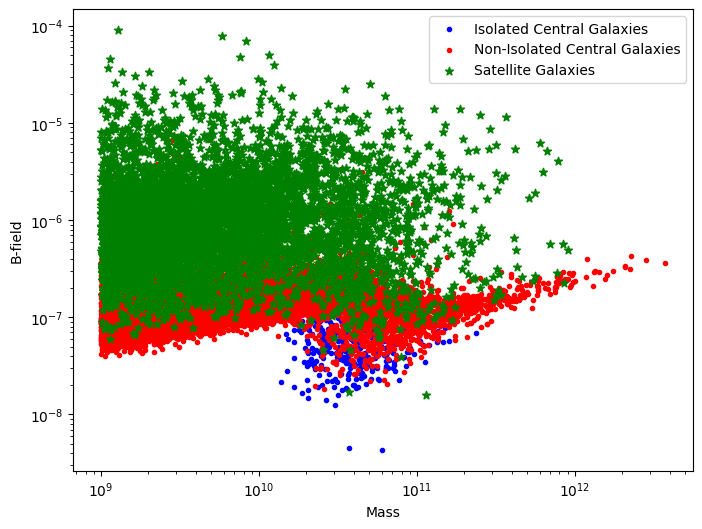

In [23]:
# Create a scatter plot
plt.figure(figsize=(8, 6))



# Plot group 1
#plt.scatter(centrals_mass, centrals_bfld, color='blue', label='Central Galaxies', marker='o')
#plot isolated centrals
plt.scatter(isolated_centrals_mass, isolated_centrals_bfld, color='blue', label='Isolated Central Galaxies', marker='.')
#plot non-isolated centrals
plt.scatter(non_isolated_centrals_mass, non_isolated_centrals_bfld, color='red', label='Non-Isolated Central Galaxies', marker='.')

# Plot group 2
plt.scatter(satellites_mass_fl, satellites_bfld_fl, color='green', label='Satellite Galaxies', marker='*')

plt.xscale('log')
plt.yscale('log')

# Add labels and title
plt.xlabel('Mass')
plt.ylabel('B-field')
#plt.title('Scatter Plot of Two Groups')


##plot in mass bin
##error bars in bfld (stdv)
# Add a legend
plt.legend()
plt.savefig('images/foo.png', bbox_inches='tight')
# Show the plot
plt.show()

# Get merger
For Pre/Post Infall Satellites

In [24]:
#Box boundary 
L=75000. #kpc
halfbox=L/2.   
h=0.6774 

r=iapi.get(baseUrl)
names = [sim['name'] for sim in r['simulations']]
i = names.index('TNG100-1')
simulation = iapi.get( r['simulations'][i]['url'] )
snaps = iapi.get( simulation['snapshots'] )

In [25]:

def gettree(subid, par_dir):
    #pull the z=0 merger tree for a subhlao
    #some subhalos don't have merger trees
    fName = str(par_dir)+'trees/sublink_mpb_'+str(subid)
    if path.exists(fName+'.hdf5'):
        return(fName+'.hdf5')
    url='https://www.tng-project.org/api/TNG100-1/snapshots/99/subhalos/'+str(subid)+'/sublink/mpb.hdf5'
    tree=iapi.get(url,fName=fName)
    return(tree)

def getredshift(snapnum):
    #convert a snapshot number to a redshift
    return(snaps[snapnum]['redshift'])

In [26]:
#example test. snapshot 98 corresponds to z~0.0095
getredshift(98)
print(IDs_m[500])
print(dirc)

31345
/Users/alexpoulin/Downloads/git/TNG/TNG_workshop/TNG_workshop_data/


## Real Join Time
Note that this code defines joining time as the time since a satellite first approached its FoF group center within 3*R200 (R200 is a measurement of radius).

For magnetic field project, define joining time as the earliest time when the host and satellite had the same SubhaloGrNr 

In [27]:
def jointime(ID,hostID, par_dir):
    """
    Use the satellite and host trees to find the joining redshift of a satellite based on when it first approached its z=0 FoF group within 3R200
    Identify the change in satellite parameters since they joined
    """


    #fetch the merger tree for the satellite
    try:
        print(f'attempting tree http for: {ID}, {hostID}')
        mpb1 = gettree(ID, dirc)
    except:
        print(f'failure in tree http for: {ID}, {hostID}')
        #return(np.nan,np.nan,np.nan, np.nan, np.nan, np.nan, np.nan,np.nan, np.nan,np.nan,np.nan,np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan)
        return(np.nan,np.nan,np.nan,np.nan,np.nan, np.nan, np.nan, np.nan, np.nan, np.nan,
               np.nan, np.nan, np.nan) #correlates to R200 = 1, 2, 3
    f = h5py.File(mpb1,'r')
    #grPos = f['GroupPos'][:]
    subPos = f['SubhaloPos'][:]
    #grR200 = f['Group_R_Crit200'][:]
    snapnum= f['SnapNum'][:]
    #grVel = f['GroupVel'][:]
    subVel = f['SubhaloVel'][:]
    subMasstype = f['SubhaloMassType'][:]
    progID = f['SubfindID'][:]
    
    #fetch the merger tree for the satellite's host

    mpbhost =gettree(hostID, dirc)
    #print(mpbhost)
    fh = h5py.File(mpbhost,'r')
    grPos = fh['GroupPos'][:]
    grR200 = fh['Group_R_Crit200'][:]
    grVel = fh['SubhaloVel'][:]
    hostprog = fh['SubhaloID']
    

    # to compare distances, first make arrays the same shapes
    # sometimes trees are "truncated," meaning they don't go all the way back to the start of the simulation
    if len(grPos)>len(subPos):         
        grPos=grPos[0:len(subPos),:]
        grR200=grR200[0:len(subPos)]
        grVel = grVel[0:len(subPos),:]

    elif len(grPos)<len(subPos):
        subPos=subPos[0:len(grPos),:]
        subVel=subVel[0:len(grPos),:]
        snapnum = snapnum[0:len(grPos)]
        subMasstype = subMasstype[0:len(grPos),:]

    
    #Taking a square root is computationally inefficient.
    #Because distance in 3D is calculated with x^2+y^2+z^2 = distance^2,
    #I just work with distances in squares until the last step

    grR200sq = np.multiply(grR200,grR200) #looking within 3R200 to get joining time for more satellites
    
    #Find the relative distance between two galaxies
    difpos=np.subtract(subPos,grPos)
    
    #The simulation uses repeating boundary conditions. 
    # So two galaxies can be quite close, even if they are technically at either end of the box
    #I can explain further when we meet to discuss

    #Replace values that are affected by boundary conditions
    difpos = np.where(abs(difpos)>halfbox,abs(difpos)-L, difpos)
    
    #Find the distance square between satellite and central as a function of redshift
    distsq=np.sum(np.square(difpos),axis=1)


    wh=np.nonzero((distsq<grR200sq))
    
    #print(wh.any)
    #Separation at z=0
    sep_z0 = np.sqrt(distsq[0])
    sep_norm = sep_z0/grR200[0]
    #Find when the 
    closeind = np.argmin(distsq)
    closest = np.sqrt(distsq[closeind])
    closest_norm = closest/grR200[closeind]
    closest_z = getredshift(snapnum[closeind])
    
    
    
    
    #####may need to do check before and after since they could cross 
    # super fast so it crosses but not within tolerance
    #Find when the satellite first crosses 1,= R_200
    #aka find the index at which the distsq is roughly 1 with a tolerance of 0.1:
    cross1R200ind = np.where((distsq<=1*grR200sq))
    cross2R200ind = np.where((distsq<=4*grR200sq))
    cross3R200ind = np.where((distsq<=9*grR200sq))
    if len(cross1R200ind[0])>0:
        first1R200 = np.sqrt(distsq[cross1R200ind[0][0]])
    else:
        first1R200 = np.nan
    if len(cross2R200ind[0])>0:
        first2R200 = np.sqrt(distsq[cross2R200ind[0][0]])
    else:
        first2R200 = np.nan
    if len(cross3R200ind[0])>0:
        first3R200 = np.sqrt(distsq[cross3R200ind[0][0]])
    else:
        first3R200 = np.nan
    #print(first1R200)
    #print(type(first1R200))
    
    
    #wh=np.nonzero((distsq<grR200sq) & (distsq>4*grR200sq))
    
    
    
    
    
    if len(wh[0])==0: 
        #in some cases, the satellite has never approached within the required distance
        #this shouldn't trigger when satellite joining redshift is defined by SubhaloGrNr
        print('not within 3')
        #return(np.nan,sep_z0,sep_norm, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, closest,closest_norm,closest_z, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan)
        return(np.nan,sep_z0,sep_norm,np.nan,closest, closest_norm, closest_z, np.nan, np.nan, np.nan,
               first1R200, first2R200, first3R200) #correlates to R200 = 1, 2, 3

    
    #find the index at which the satellite joined 
    joinind = max(wh[0])
    #print(snapnum[joinind])
    #print(grR200sq[wh],distsq[wh])
    whinside=snapnum[wh]
    whID = progID[wh] #ID of the "progenitor" galaxy of the subhalo, used to pull progenitor cutout in other code
    #print(whinside)
    minind = np.argmin(whinside)
    
    joinsnap=whinside[minind]
    joinprog = whID[minind]
    #print(joinsnap, snapnum, len(snapnum))
    joinred = getredshift(joinsnap)
    #joinind = 99-joinsnap
    #if joinind == len(snapnum): joinind=-1
    
    '''
    #Join scale factor (a), a=1 at z=0
    a=1./(1+joinred) #needed for converting comoving kiloparsecs, don't worry about this for magnetic field project
    
    #Get change in parameters since satellite joined:
    
    #Change in gas mass
    M_gas_0 = subMasstype[0][0]
    M_gas_join = subMasstype[joinind][0]
    del_M = M_gas_0 - M_gas_join
    
    #to understand kinetic energy, want to know the typical change in different masses
    del_M_total = np.sum(subMasstype[0]) - np.sum(subMasstype[joinind])
    del_M_dm = subMasstype[0][1] - subMasstype[joinind][1]
    del_M_stars = subMasstype[0][4] - subMasstype[joinind][4]
    
    #Change in kinetic energy (both all mass and star and gas mass)
    M_all_0 = np.sum(subMasstype[0])
    M_all_join = np.sum(subMasstype[joinind])
    M_lim_0 = M_gas_0 + subMasstype[0][4] #gas+stars
    M_lim_join = M_gas_join + subMasstype[joinind][4]
    
    rel_velsq_0 = np.sum(np.square((subVel[0]-grVel[0])))
    #print(rel_velsq_0)
    rel_velsq_join = np.sum(np.square((subVel[joinind]-grVel[joinind]*(1/a))))
    
    del_vsq = rel_velsq_0-rel_velsq_join
    
    #kinetic energy
    T_all_0 = 0.5*M_all_0*rel_velsq_0
    T_all_join = 0.5*M_all_join*rel_velsq_join
    del_T_all = T_all_0 - T_all_join
    
    T_lim_0 = 0.5*M_lim_0*rel_velsq_0
    T_lim_join = 0.5*M_lim_join*rel_velsq_join
    del_T_lim = T_lim_0 - T_lim_join
    
    #angular momentum
    L_0 = M_all_0*np.sqrt(rel_velsq_0)*sep_z0
    L_join = M_all_join*np.sqrt(rel_velsq_join)*np.sqrt(distsq[joinind])
    del_L = L_0-L_join
    
    '''
    
    print(f'joinsnap: {joinsnap}')
    
    s_mass_j = subMasstype[joinind][4]
    
    hostprog_ID  = hostprog[joinind]
    
    #return(joinred,sep_z0,sep_norm, del_M, del_T_all, del_T_lim, del_M_total,del_M_dm, del_M_stars,del_vsq,joinsnap,closest, closest_norm, closest_z, joinprog, del_L, s_mass_j, hostprog_ID, L_join, L_0)
    return(joinred,sep_z0,sep_norm,joinsnap,closest, closest_norm, closest_z, joinprog, s_mass_j, hostprog_ID,
           first1R200, first2R200, first3R200) #correlates to R200 = 1, 2, 3


## iterate over all satellites

In [28]:
#return(joinred,sep_z0,sep_norm,joinsnap,closest, closest_norm, 
# closest_z, joinprog, s_mass_j, hostprog_ID)

joinred = np.full(len(IDs_m), np.nan)
sep = np.full(len(IDs_m), np.nan)
sep_norm = np.full(len(IDs_m), np.nan)
#del_M = np.full(len(IDs_m), np.nan)
#del_T_all = np.full(len(IDs_m), np.nan)
#del_T_lim = np.full(len(IDs_m), np.nan)
#del_M_total = np.full(len(IDs_m), np.nan)
#del_M_dm = np.full(len(IDs_m), np.nan)
#del_M_stars = np.full(len(IDs_m), np.nan)
#del_vsq = np.full(len(IDs_m), np.nan)
joinsnap = np.full(len(IDs_m), np.nan)
closest = np.full(len(IDs_m), np.nan)
closest_norm = np.full(len(IDs_m), np.nan)
closest_z = np.full(len(IDs_m), np.nan)
joinprog = np.full(len(IDs_m), np.nan)
#del_L  = np.full(len(IDs_m), np.nan)
s_mass_j = np.full(len(IDs_m),np.nan)
hostprogID = np.full(len(IDs_m), np.nan)
#L_join = np.full(len(IDs_m), np.nan)
#L_0  = np.full(len(IDs_m),np.nan)
cross1R200 = np.full(len(IDs_m), np.nan)
cross2R200 = np.full(len(IDs_m), np.nan)
cross3R200 = np.full(len(IDs_m), np.nan)

#iterate over each value in groupNum_uniq
for i in range(0,len(centrals_mass)):    
    #go through each iteration of satellites and go through the length of that
    for j in range(0,len(satellites_mass[i])):
        #print(subid[i],hostid[i])
        '''
        joinred[i], sep[i], sep_norm[i], del_M[i], del_T_all[i], del_T_lim[i], 
        del_M_total[i],del_M_dm[i],del_M_stars[i], 
        del_vsq[i], joinsnap[i], closest[i],closest_norm[i], closest_z[i], 
        joinprog[i], del_L[i], s_mass_j[i], 
        hostprogID[i], L_join[i], L_0[i] = jointime(satellites_ids[i][j],centrals_ids[i], dirc)
        '''
        joinred[i], sep[i], sep_norm[i], joinsnap[i], closest[i], closest_norm[i], closest_z[i], joinprog[i], s_mass_j[i], hostprogID[i], cross1R200[i], cross2R200[i], cross3R200[i] = jointime(satellites_ids[i][j],centrals_ids[i], dirc)

print(joinred)
    

attempting tree http for: 1, 0
not within 3
attempting tree http for: 2, 0
joinsnap: 99
attempting tree http for: 3, 0
not within 3
attempting tree http for: 4, 0
not within 3
attempting tree http for: 5, 0
joinsnap: 99
attempting tree http for: 6, 0
joinsnap: 96
attempting tree http for: 7, 0
joinsnap: 74
attempting tree http for: 8, 0
joinsnap: 98
attempting tree http for: 9, 0
joinsnap: 91
attempting tree http for: 10, 0
joinsnap: 89
attempting tree http for: 11, 0
joinsnap: 65
attempting tree http for: 12, 0
not within 3
attempting tree http for: 13, 0
joinsnap: 78
attempting tree http for: 14, 0
joinsnap: 97
attempting tree http for: 15, 0
not within 3
attempting tree http for: 16, 0
joinsnap: 79
attempting tree http for: 17, 0
not within 3
attempting tree http for: 18, 0
joinsnap: 78
attempting tree http for: 19, 0
joinsnap: 53
attempting tree http for: 20, 0
not within 3
attempting tree http for: 21, 0
joinsnap: 52
attempting tree http for: 22, 0
joinsnap: 91
attempting tree htt

In [29]:
#test what is s_mass_j
print(s_mass_j)
print(satellites_mass)
print(closest_z)

print(len(closest_z))
print(len(s_mass_j))

print(len(closest_z[~np.isnan(closest_z)]))
print(len(satellites_mass_fl))
print(satellites_mass_fl)

print(len(cross1R200))
print(len(cross2R200))
print(len(cross3R200))


[       nan 0.13510531        nan ...        nan        nan        nan]
[[np.float32(558791700000.0), np.float32(627139600000.0), np.float32(171551460000.0), np.float32(133340406000.0), np.float32(192150200000.0), np.float32(289372440000.0), np.float32(192698550000.0), np.float32(223140360000.0), np.float32(201115710000.0), np.float32(236774640000.0), np.float32(260189700000.0), np.float32(83734815000.0), np.float32(97074135000.0), np.float32(168427320000.0), np.float32(71538480000.0), np.float32(100577210000.0), np.float32(78666190000.0), np.float32(86144800000.0), np.float32(132973175000.0), np.float32(42819490000.0), np.float32(109763940000.0), np.float32(48091492000.0), np.float32(107320250000.0), np.float32(29036093000.0), np.float32(67762176000.0), np.float32(49894117000.0), np.float32(44136755000.0), np.float32(37582803000.0), np.float32(29564340000.0), np.float32(51341160000.0), np.float32(77012390000.0), np.float32(44120072000.0), np.float32(39299270000.0), np.float32(51320033

## Define Pre/Post Infall based on Closest Approach
We want to define join times by when the satellite was no longer in the same FoF group as its z=0 central.


Find the distance between satellites and central as a function of redshift
Save the "joining redshift" of each satellite galaxy, which will be the highest redshift (lowest snapshot #) that the satellite and its central had the same SubhaloGrNr

If satellites are the closest they've ever been to their central galaxy at present-day (present day means snapnum=99, corresponding to z=0), define them to be pre-infall satellites.
If satellites were closer to their central galaxy some time between present-day and when they joined the same FoF group as their hosts, define them to be post-infall satellites. 
For post-infall satellites, save their "pericenter distance" which is the separation between central and satellite galaxy when they were at their closest. Normalize the pericenter distance by the group's R200 at that redshift (see the definition of "closest_norm" in the example code to see what I mean).

In [30]:
#given closest_z, we want to iterate over all satellites and if their
#closest_z has z=0, then they should be added as a pre-infall satellites and pre-infall satelite mass, bfld, and ID should be saved
#otherwise they should be added as post-infall satellites and post-infall satellite mass, bfld, and ID should be saved
#also if they are post-infall satellites, save another array with their pericenter distance (closest_norm)

pre_infall = []
pre_infall_mass = []
pre_infall_bfld = []
pre_infall_ID = []

post_infall = []
post_infall_mass = []
post_infall_bfld = []
post_infall_ID = []
post_infall_closest_norm = []

for i in range(0,len(satellites_mass_fl)):
    #if less than 10^-7 then pre_infall
    if closest_z[i] < 0.0000001:
        pre_infall.append(closest_z[i])
        pre_infall_mass.append(satellites_mass_fl[i])
        pre_infall_bfld.append(Bfld_m[i])
        pre_infall_ID.append(IDs_m[i])
    else:
        post_infall.append(closest_z[i])
        post_infall_mass.append(satellites_mass_fl[i])
        post_infall_bfld.append(satellites_bfld_fl[i])
        post_infall_ID.append(IDs_m[i])
        post_infall_closest_norm.append(closest_norm[i])
        #note i dont think id is correct but then again we shouldnt need to use it
        

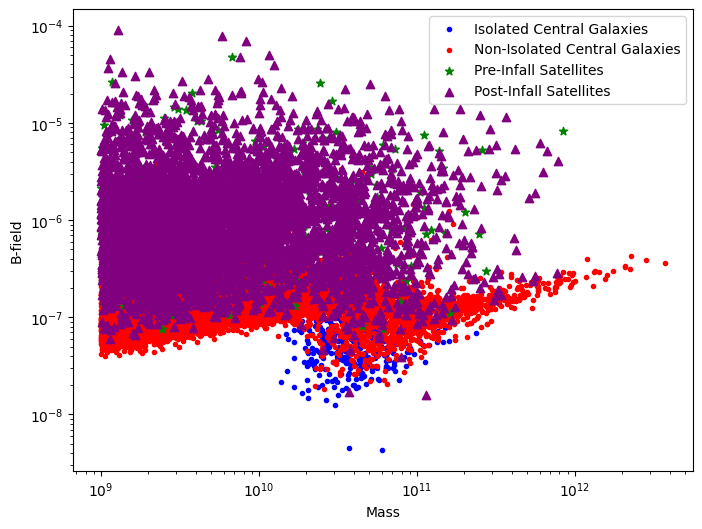

In [31]:
#plot isolated, non-isolated centrals
#and pre-infall, post-infall satellites (Without binning)

plt.figure(figsize=(8, 6))

#plot isolated centrals
plt.scatter(isolated_centrals_mass, isolated_centrals_bfld, color='blue', label='Isolated Central Galaxies', marker='.')
#plot non-isolated centrals
plt.scatter(non_isolated_centrals_mass, non_isolated_centrals_bfld, color='red', label='Non-Isolated Central Galaxies', marker='.')
#plot pre-infall satellites
plt.scatter(pre_infall_mass, pre_infall_bfld, color='green', label='Pre-Infall Satellites', marker='*')
#plot post-infall satellites
plt.scatter(post_infall_mass, post_infall_bfld, color='purple', label='Post-Infall Satellites', marker='^')

plt.xscale('log')
plt.yscale('log')

# Add labels and title
plt.xlabel('Mass')
plt.ylabel('B-field')
#plt.title('Scatter Plot of Two Groups')

# Add a legend
plt.legend()

# Show the plot
plt.show()



## Plot with Binning

In [ ]:
#sort the pre
pre_infall_mass_sort, pre_infall_bfld_sort = sort_mass(pre_infall_mass, pre_infall_bfld)
post_infall_mass_sort, post_infall_bfld_sort = sort_mass(post_infall_mass, post_infall_bfld)

#sort centrals
isolated_centrals_mass_sort, isolated_centrals_bfld_sort = sort_mass(isolated_centrals_mass, isolated_centrals_bfld)
non_isolated_centrals_mass_sort, non_isolated_centrals_bfld_sort = sort_mass(non_isolated_centrals_mass, non_isolated_centrals_bfld)

#bin the data
bin_size = 100
pre_infall_mass_bin, pre_infall_mass_bin_er = bin_data(pre_infall_mass_sort, bin_size)
pre_infall_bfld_bin, pre_infall_bfld_bin_er = bin_data(pre_infall_bfld_sort, bin_size)
post_infall_mass_bin, post_infall_mass_bin_er = bin_data(post_infall_mass_sort, bin_size)
post_infall_bfld_bin, post_infall_bfld_bin_er = bin_data(post_infall_bfld_sort, bin_size)
isolated_centrals_mass_bin, isolated_centrals_mass_bin_er = bin_data(isolated_centrals_mass_sort, bin_size)
isolated_centrals_bfld_bin, isolated_centrals_bfld_bin_er = bin_data(isolated_centrals_bfld_sort, bin_size)
non_isolated_centrals_mass_bin, non_isolated_centrals_mass_bin_er = bin_data(non_isolated_centrals_mass_sort, bin_size)
non_isolated_centrals_bfld_bin, non_isolated_centrals_bfld_bin_er = bin_data(non_isolated_centrals_bfld_sort, bin_size)


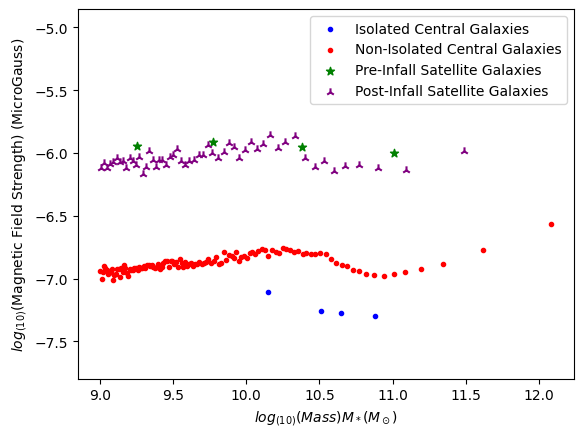

In [42]:
plot_gen(isolated_centrals_mass_bin, isolated_centrals_bfld_bin, non_isolated_centrals_mass_bin, non_isolated_centrals_bfld_bin, pre_infall_mass_bin, pre_infall_bfld_bin, post_infall_mass_bin, post_infall_bfld_bin, 'binnedz-0.png', log=False)


# Define prefall/postfall based on Cross R200
It may be the case that whatever process is causing the magnetic field to amplify is occurring well before "infall" as it is currently defined. We can test different definitions of infall as when the satellite first cross 1, 2, or 3 R_200. R_200 corresponds to the virial radius of the FoF group (Group_R_Crit200 in the FoF catalog). 

In [78]:
print(cross3R200)
#check how many nans and non nans
print(sum(np.isnan(cross1R200)))
print(len(cross1R200)-sum(np.isnan(cross1R200)))
print(np.isnan(cross1R200))

[         nan 104.62661743          nan ...          nan          nan
          nan]
19579
1473
[ True False  True ...  True  True  True]


In [79]:
def defInfall(condition):
    def_pre_infall = []
    def_pre_infall_m = []
    def_pre_infall_b = []
    def_pre_infall_ID = []

    def_post_infall = []
    def_post_infall_m = []
    def_post_infall_b = []
    def_post_infall_ID = []
    for i in range(0,len(satellites_mass_fl)):
        #if less than 10^-9 then pre_infall
        #print(cross3R200[i])
        if np.isnan(condition[i]):
            def_pre_infall.append(closest_z[i])
            def_pre_infall_m.append(satellites_mass_fl[i])
            def_pre_infall_b.append(satellites_bfld_fl[i])
            def_pre_infall_ID.append(IDs_m[i])
        else:
            def_post_infall.append(closest_z[i])
            def_post_infall_m.append(satellites_mass_fl[i])
            def_post_infall_b.append(satellites_bfld_fl[i])
            def_post_infall_ID.append(IDs_m[i])
            #note i dont think id is correct but then again we shouldnt need to use it
    return def_pre_infall, def_pre_infall_m, def_pre_infall_b, def_pre_infall_ID, def_post_infall, def_post_infall_m, def_post_infall_b, def_post_infall_ID

In [80]:
#check how many cross1R200 are not nan
print(len(cross1R200)-sum(np.isnan(cross1R200)))
#check how many cross2R200 are not nan
print(len(cross2R200)-sum(np.isnan(cross2R200)))
#check how many cross3R200 are not nan
print(len(cross3R200)-sum(np.isnan(cross3R200)))

1473
1791
1950


In [81]:
pre_infall_1, pre_infall_1_mass, pre_infall_1_bfld, pre_infall_1_ID, post_infall_1, post_infall_1_mass, post_infall_1_bfld, post_infall_1_ID = defInfall(cross1R200)
pre_infall_2, pre_infall_2_mass, pre_infall_2_bfld, pre_infall_2_ID, post_infall_2, post_infall_2_mass, post_infall_2_bfld, post_infall_2_ID = defInfall(cross2R200)
pre_infall_3, pre_infall_3_mass, pre_infall_3_bfld, pre_infall_3_ID, post_infall_3, post_infall_3_mass, post_infall_3_bfld, post_infall_3_ID = defInfall(cross3R200)

#math.isclose(a, b, rel_tol=1e-9, abs_tol=0.0)

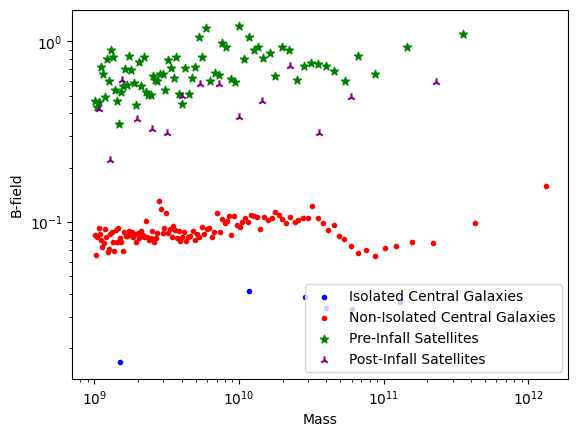

In [82]:
#sort the pre
pre_infall_1_mass_sort, pre_infall_1_bfld_sort = sort_mass(pre_infall_1_mass, pre_infall_1_bfld)
post_infall_1_mass_sort, post_infall_1_bfld_sort = sort_mass(post_infall_1_mass, post_infall_1_bfld)

#centrals already sorted from before

#bin the data (centrals already binned from before)
bin_size = 100
pre_infall_1_mass_bin, pre_infall_1_mass_bin_er = bin_data(pre_infall_1_mass_sort, bin_size)
pre_infall_1_bfld_bin, pre_infall_1_bfld_bin_er = bin_data(pre_infall_1_bfld_sort, bin_size)
post_infall_1_mass_bin, post_infall_1_mass_bin_er = bin_data(post_infall_1_mass_sort, bin_size)
post_infall_1_bfld_bin, post_infall_1_bfld_bin_er = bin_data(post_infall_1_bfld_sort, bin_size)

#plot
plot_gen(isolated_centrals_mass_bin, isolated_centrals_bfld_bin, 
         non_isolated_centrals_mass_bin, non_isolated_centrals_bfld_bin, 
         pre_infall_1_mass_bin, pre_infall_1_bfld_bin, 
         post_infall_1_mass_bin, post_infall_1_bfld_bin, 'binnedz-cross-1R200.png')



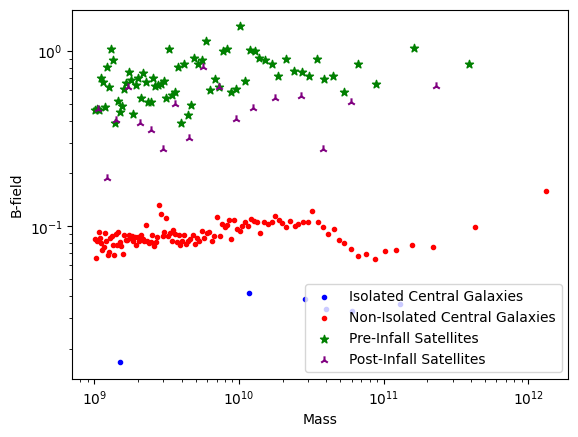

In [83]:
#sort the pre
pre_infall_2_mass_sort, pre_infall_2_bfld_sort = sort_mass(pre_infall_2_mass, pre_infall_2_bfld)
post_infall_2_mass_sort, post_infall_2_bfld_sort = sort_mass(post_infall_2_mass, post_infall_2_bfld)

pre_infall_2_mass_bin, pre_infall_2_mass_bin_er = bin_data(pre_infall_2_mass_sort, bin_size)
pre_infall_2_bfld_bin, pre_infall_2_bfld_bin_er = bin_data(pre_infall_2_bfld_sort, bin_size)
post_infall_2_mass_bin, post_infall_2_mass_bin_er = bin_data(post_infall_2_mass_sort, bin_size)
post_infall_2_bfld_bin, post_infall_2_bfld_bin_er = bin_data(post_infall_2_bfld_sort, bin_size)

#plot
plot_gen(isolated_centrals_mass_bin, isolated_centrals_bfld_bin, 
         non_isolated_centrals_mass_bin, non_isolated_centrals_bfld_bin, 
         pre_infall_2_mass_bin, pre_infall_2_bfld_bin, 
         post_infall_2_mass_bin, post_infall_2_bfld_bin, 'binnedz-cross-2R200.png')

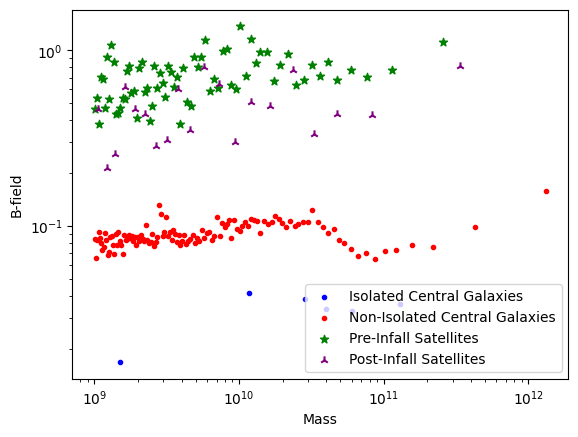

In [84]:
#sort the pre
pre_infall_3_mass_sort, pre_infall_3_bfld_sort = sort_mass(pre_infall_3_mass, pre_infall_3_bfld)
post_infall_3_mass_sort, post_infall_3_bfld_sort = sort_mass(post_infall_3_mass, post_infall_3_bfld)

pre_infall_3_mass_bin, pre_infall_3_mass_bin_er = bin_data(pre_infall_3_mass_sort, bin_size)
pre_infall_3_bfld_bin, pre_infall_3_bfld_bin_er = bin_data(pre_infall_3_bfld_sort, bin_size)
post_infall_3_mass_bin, post_infall_3_mass_bin_er = bin_data(post_infall_3_mass_sort, bin_size)
post_infall_3_bfld_bin, post_infall_3_bfld_bin_er = bin_data(post_infall_3_bfld_sort, bin_size)

#plot
plot_gen(isolated_centrals_mass_bin, isolated_centrals_bfld_bin, 
         non_isolated_centrals_mass_bin, non_isolated_centrals_bfld_bin, 
         pre_infall_3_mass_bin, pre_infall_3_bfld_bin, 
         post_infall_3_mass_bin, post_infall_3_bfld_bin, 'binnedz-cross-3R200.png')

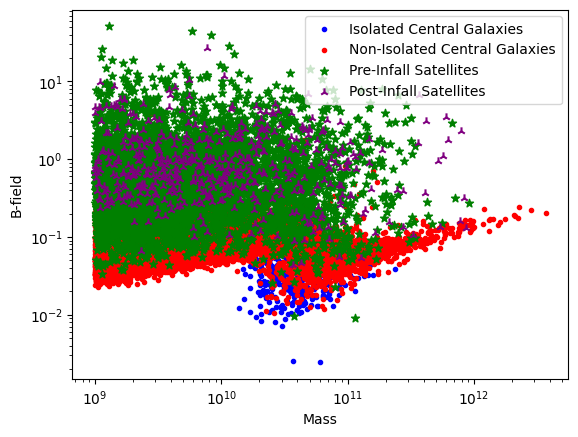

In [85]:
#plot with no binning
plot_gen(isolated_centrals_mass, isolated_centrals_bfld,
            non_isolated_centrals_mass, non_isolated_centrals_bfld,
            pre_infall_1_mass, pre_infall_1_bfld,
            post_infall_1_mass, post_infall_1_bfld, 'cross-1R200-trynafix.png')

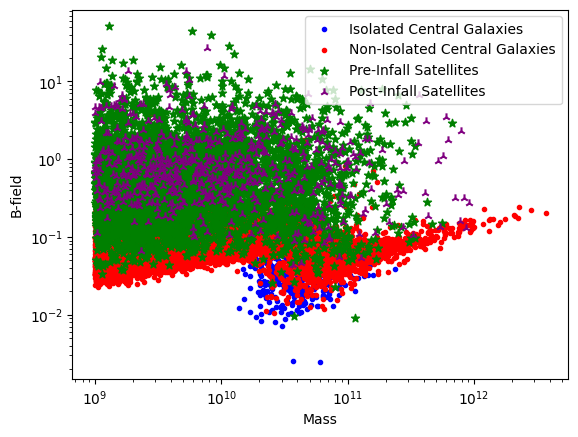

In [86]:
#plot with no binning
plot_gen(isolated_centrals_mass, isolated_centrals_bfld,
            non_isolated_centrals_mass, non_isolated_centrals_bfld,
            pre_infall_2_mass, pre_infall_2_bfld,
            post_infall_2_mass, post_infall_2_bfld, 'cross-2R200-trynafix.png')

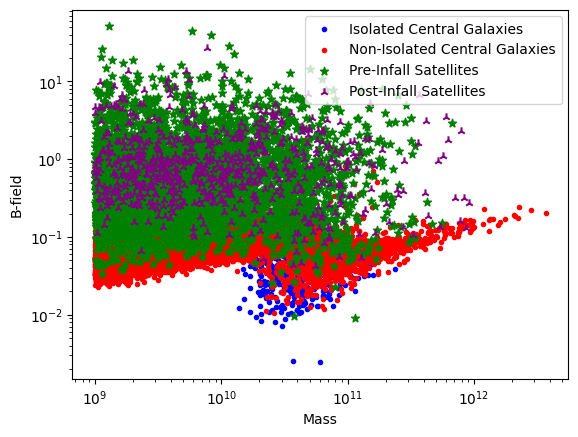

In [87]:
#plot with no binning
plot_gen(isolated_centrals_mass, isolated_centrals_bfld,
            non_isolated_centrals_mass, non_isolated_centrals_bfld,
            pre_infall_3_mass, pre_infall_3_bfld,
            post_infall_3_mass, post_infall_3_bfld, 'cross-3R200-trynafix.png')

## Draw Contours and Error bars

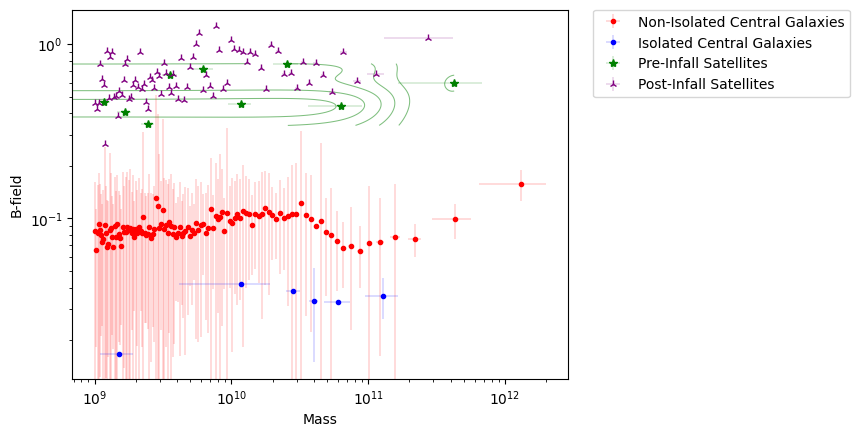

In [88]:
##closest approach pre/postinfall plots with binning, contour and error bars
plot_wcontour(isolated_centrals_mass_bin, isolated_centrals_bfld_bin,
            non_isolated_centrals_mass_bin, non_isolated_centrals_bfld_bin,
            pre_infall_mass_bin, pre_infall_bfld_bin, 
            post_infall_mass_bin, post_infall_bfld_bin,
            isolated_centrals_mass_bin_er, isolated_centrals_bfld_bin_er,
            non_isolated_centrals_mass_bin_er, non_isolated_centrals_bfld_bin_er,
            pre_infall_mass_bin_er, pre_infall_bfld_bin_er,
            post_infall_mass_bin_er, post_infall_bfld_bin_er,
            'binned-closest-approach-contour.png')

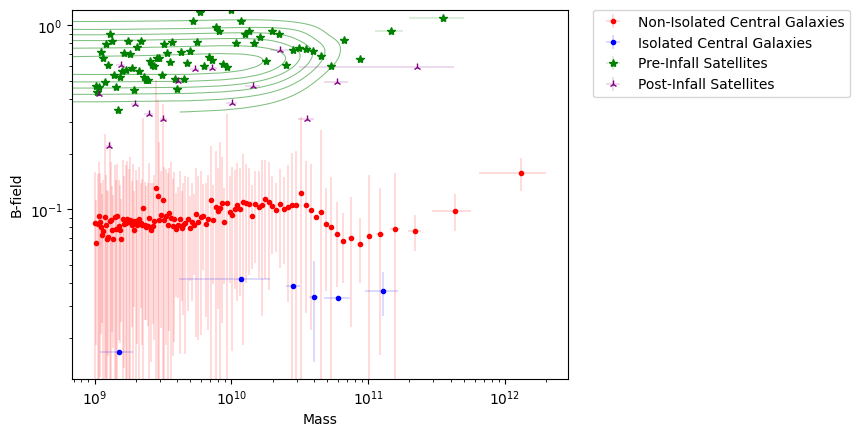

In [89]:
##1R200 approach pre/postinfall plots with binning, contour and error bars
plot_wcontour(isolated_centrals_mass_bin, isolated_centrals_bfld_bin,
            non_isolated_centrals_mass_bin, non_isolated_centrals_bfld_bin,
            pre_infall_1_mass_bin, pre_infall_1_bfld_bin, 
            post_infall_1_mass_bin, post_infall_1_bfld_bin,
            isolated_centrals_mass_bin_er, isolated_centrals_bfld_bin_er,
            non_isolated_centrals_mass_bin_er, non_isolated_centrals_bfld_bin_er,
            pre_infall_1_mass_bin_er, pre_infall_1_bfld_bin_er,
            post_infall_1_mass_bin_er, post_infall_1_bfld_bin_er,
            'binned-cross-1R200-contour.png')